# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct ellitical distortions, with a beam stop

This notebook demos measuring and correction elliptical distortion of the diffraction patterns due to imperfect electron optics.  This notebook requires that the Bragg peaks and Bragg vector map have already been measured, and if necessary, the diffraction shifts corrected.

From colin:
---

Ok so the general method is:

- Transform the data into polar coordinates.
- Measure the mean along the theta direction INSIDE a mask (for beam stop, edges)
- Measure the root-mean-square along the theta direction inside this same mask.
- Treat this as a cost function to be minimized, first with (x0,y0), ...
- ... and then with (x0, y0, B, C)  - I used the convention A = 1 for:
A x^2 + B x y + C y^2 = r^2

Example command lines:
- sFEM_160 = PolarCorr01(CBEDmean_160,s160);
- sFEM_160 = PolarCorr02(sFEM_160,100);
- sFEM_160 = PolarCorr03(sFEM_160,400);

Note that 02 and 03 are the same script, just with different variables minimized.  The biggest possible change is using a much better gradient descent, the one I used here is pretty mediocre (square lattice search).  We can discuss it more tomorrow. 

I have included all 3 masks, which you can see / edit with:
- s160 = RealspaceLattice01(s160);
- s300 = RealspaceLattice01(s300);
- s600 = RealspaceLattice01(s600);

Finally I found that with these step sizes, theta and r spacing, and cost function, all three datasets work.  However I did need a lot more iterations for 03, specifically ~400 for it to be converged.  Here are my results:
>> [sFEM_160.coefs; sFEM_300.coefs; sFEM_600.coefs]
ans =
  493.3275  476.2382    1.0000   -0.0153    1.0106
  469.5656  440.4413    1.0000   -0.0159    1.0182
  548.6982  435.1638    1.0000   -0.0020    1.0111

In order of reliability it would be 160, 300, 600, i.e. more Bragg rings = better fits.  At least the trends are the same!  Also I computed the mean CBED images like so:

- dm4 = dm4Reader();
- stack3D_160 = single(dm4.cube);
- CBEDmean_160 = mean(stack3D_160,3);

It just occurred to me that taking the max rather than the mean might be a lot better for the super sparse data like 600.  Re-running everything using:
CBEDmax_160 = mean(stack3D_160,[],3);
etc. failed for 160 and 300 (bad initial guess) but gave for 600:
>> sFEM_600.coefs
ans =
  546.7415  438.7551    1.0000   -0.0122    1.0077
which is closer for B, further for C.  Hmmm.

Oh!  All of this will run a LOT better using the Bragg map instead of the full CBED images.  Making the peaks sharper will basically fix most of these issues!  Note that in the images in Figure 11, left is the original and right is the new in polar coords, vertical direction for theta, horizontal for radial.

### Import packages, load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
import h5py

In [2]:
# Get masks

fp = "/home/ben/Projects/py4DSTEM/polar_alignment/data_polar_01.mat"
f = h5py.File(fp)
mask160 = np.array(f['sFEM_160/mask'])
mask300 = np.array(f['sFEM_300/mask'])
mask600 = np.array(f['sFEM_600/mask'])
CBEDmean160 = np.array(f['CBEDmean_160'])
CBEDmean300 = np.array(f['CBEDmean_300'])
CBEDmean600 = np.array(f['CBEDmean_600'])
f.close()

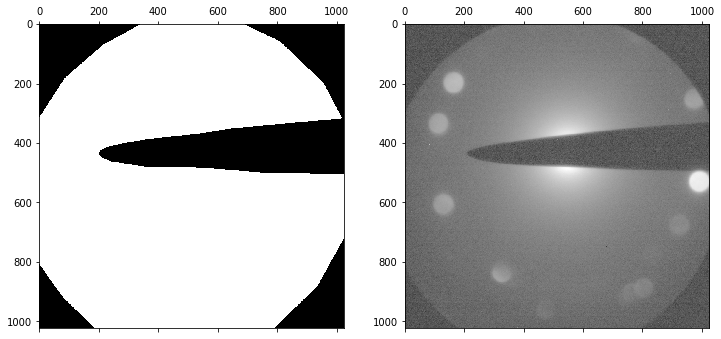

In [365]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(mask300)
ax2.matshow(CBEDmean600**0.2)
plt.show()

In [359]:
class polar_elliptical_transform(object):
    """
    This class facilitates coordinate transformation from Cartesian coordinates to polar elliptical coordinates.
    The notation / paramaterization here is:
    
            x = x0 + A*xr + C*yr
            y = y0 + B*yr + C*xr
            
    where (x,y) is a point in the Cartesian plane, (x0,y0,A,B,C) are parameters describing the transformation,
    and (xr,yr) are shorthand for
    
            xr = r*cos(theta)
            yr = r*sin(theta)
            
    Thus the transformation is from (x,y) space to (r,theta) space.  For A=B, the (r,theta) parameterization
    describes a polar coordinate system.  For A!=B, the (r,theta) parameterization describes a polar elliptical
    coordinate system in which A and B are the semi-major axis lengths, and C corresponds to a tilt of the
    theta=0 direction relative to (x,y) space.
    
    The parameters (x0,y0,A,B,C) are stored as elements of a length-5 array, in this order, at self.coeffs.
    
    Examples
    --------
    For two arrays (ar, mask) representing an image and a boolean mask: 
    
        >>> pet = polar_elliptical_transform(calibration_image=ar, mask=mask)
        >>> pet.get_polar_transform()

    will generate and store the polar transformation of ar in an array at pet.polar_ar.  Note that by default
    this is now a polar transform with A=B=1, C=0, and (x0,y0) at the center of ar.  The parameters of the
    transformation can be refined with
    
        >>> pet.fit_origin()         # Refines x0,y0
        >>> pet.fit_ellipticity()    # Refines x0,y0,A,B,C
    
    and the polar transform can then be recalculated with
    
        >>> pet.get_polar_transform()    
    """
    def __init__(self, calibration_image, mask=None, x0_init=None, y0_init=None, dr=1, dtheta=2, r_range=500):
        """
        Initialize a polar_elliptical_transform instance.
        
        Accepts:
            calibration_image   (2D float array) image used to calibrate the coordinates and elliptical distortion
            mask                (2D bool array) pixels in calibration_image to use; False pixels are ignored
            x0_init             (float) initial center x coord. If None, initialize to the image center
            y0_init             (float) initial center y coord. If None, initialize to the image center
            dr                  (float) radial bin size
            dtheta              (float) angular bin size, in degrees
            r_range             (float or list/tuple of two floats) the min/max r values. If r_range is a number,
                                it is taken as the max r_value, and the min value is set to 0
        """   
        # Setup transformation parameters
        self.calibration_image = calibration_image
        if mask is None:
            self.mask = np.ones_like(calibration_image, dtype=bool)
        else:
            self.mask = mask
        self.dr = dr
        self.dtheta = np.radians(dtheta)
        try:
            self.r_range = [r_range[0],r_range[1]]
        except TypeError:
            self.r_range = [0,r_range]
        
        # Cartesian coordinates
        self.Nx = calibration_image.shape[0]
        self.Ny = calibration_image.shape[1]
        self.yy,self.xx = np.meshgrid(np.arange(self.Ny),np.arange(self.Nx))

        # Polar coordinates
        r_bins = np.arange(self.r_range[0]+self.dr/2.,self.r_range[1]+self.dr/2.,self.dr)    # values here
        theta_bins = np.arange(-np.pi+self.dtheta/2.,np.pi+self.dtheta/2.,self.dtheta)       # are bin centers
        self.Nr, self.Nt = len(r_bins),len(theta_bins)
        self.rr, self.tt = np.meshgrid(r_bins, theta_bins)

        # Initial parameters
        self.coeffs = np.zeros(5)    # coeffs: [x0, y0, A, B, C]
        if x0_init is not None:
            self.coeffs[0] = x0_init
        else:
            self.coeffs[0] = 0.5*self.Nx
        if y0_init is not None:
            self.coeffs[1] = y0_init
        else:
            self.coeffs[1] = 0.5*self.Ny
        self.coeffs[2] = 1
        self.coeffs[3] = 1
        self.coeffs[4] = 0
    
    def get_polar_transform(self, ar=None, mask=None):
        """
        Get the polar transformation of an array ar, or if ar is None, of self.calibration_image.
        
        Accepts:
            ar              (2D array or None) the array to transform; if None, use self.calibration_image
            mask            (2D array or None) mask indicating pixels to ignore; if None, use self.mask
            
        Returns:
            polar_ar        (2D array) the polar transformation of ar
            polar_mask      (2D array) the polar transformation of mask
        """
        if ar is None:
            ar = self.calibration_image
        if mask is None:
            mask = self.mask
        
        xr = self.rr * np.cos(self.tt)
        yr = self.rr * np.sin(self.tt)
        x = self.coeffs[0] + self.coeffs[2]*xr + self.coeffs[4]*yr
        y = self.coeffs[1] + self.coeffs[3]*yr + self.coeffs[4]*xr
        
        transform_mask = (x>1)*(y>1)*(x<self.Nx-1)*(y<self.Ny-1)
        xF = np.floor(x[transform_mask])
        yF = np.floor(y[transform_mask])  
        dx = x[transform_mask] - xF
        dy = y[transform_mask] - yF

        x_inds = np.vstack((xF,xF+1,xF,  xF+1)).astype(int)
        y_inds = np.vstack((yF,yF  ,yF+1,yF+1)).astype(int)
        weights = np.vstack(((1-dx)*(1-dy),
                             (  dx)*(1-dy),
                             (1-dx)*(  dy),
                             (  dx)*(  dy)))
    
        transform_mask = transform_mask.ravel()
        self.polar_ar = np.zeros(np.prod(self.rr.shape))
        self.polar_ar[transform_mask] = np.sum(ar[x_inds,y_inds]*weights,axis=0)
        self.polar_ar = np.reshape(self.polar_ar,self.rr.shape)

        self.polar_mask = np.zeros(np.prod(self.rr.shape))
        self.polar_mask[transform_mask] = np.sum(self.mask[x_inds,y_inds]*weights,axis=0)
        self.polar_mask = np.reshape(self.polar_mask,self.rr.shape)
        
        return self.polar_ar, self.polar_mask
    
    def get_polar_score(self):
        """
        Get the score - the RMSD divided by the mean along the theta direction - for self.polar_ar while
        masking off self.polar_mask.
        
        Returns:
            score       (float) the score
            RMSD        (1D array) the RMSD of self.polar_ar[self.polar_mask] along the theta direction
            mean        (1D array) the mean of self.polar_ar[self.polar_mask] along the theta direction
        """
        # Mean along theta
        self.mean = np.sum(self.polar_ar*self.polar_mask, axis=0)
        mask_sum = np.sum(self.polar_mask, axis=0)
        divmask = mask_sum > 1e-2
        self.mean[divmask] = self.mean[divmask] / mask_sum[divmask]
        self.mean[divmask==False] = 0
        
        # RMS along theta
        self.RMSD = (self.polar_ar - np.tile(self.mean,(self.Nt,1)))**2
        self.RMSD = np.sum(self.RMSD, axis=0)
        self.RMSD[divmask] = np.sqrt(self.RMSD[divmask] / mask_sum[divmask])
        self.RMSD[divmask==False] = 0

        # Score
        self.score = np.sum(self.RMSD[divmask] / self.mean[divmask]) / self.Nr
        
        return self.score, self.RMSD, self.mean
        
    def fit_origin(self, n_iter, step_size_x0_init=1, step_size_y0_init=1, step_scale=0.9):
        """
        Find the origin by minimizing a cost function (theta-integrated RMSD of the polar transform).
        
        Accepts:
            n_iter
            step_size_x0_init
            step_size_y0_init
            step_scale
            
        Returns:
            x0
            y0
            scores
        """
        scores = []
        
        # Initial step sizes
        step_sizes = np.zeros(5)
        step_sizes[0] = step_size_x0_init
        step_sizes[1] = step_size_y0_init

        # Initial polar transform and score
        self.get_polar_transform()
        score,_,_ = self.get_polar_score()
        scores.append(score)
        
        xs,ys = [],[]
        xs.append(self.coeffs[0])
        ys.append(self.coeffs[1])
        
        # Main loop
        for i in range(n_iter):
            
            # Loop over x0,y0, testing score of polar transforms with updated values of each
            n_steps = 0
            for j in range(2):
                # Test new coefficient and update
                self.coeffs[j] += step_sizes[j]
                self.get_polar_transform()
                test_score,_,_ = self.get_polar_score()

                if test_score < score:
                    score = test_score
                    n_steps += 1
                else:
                    self.coeffs[j] -= 2*step_sizes[j]
                    self.get_polar_transform()
                    test_score,_,_ = self.get_polar_score()
                    if test_score < score:
                        score = test_score
                        n_steps += 1
                    else:
                        self.coeffs[j] += step_sizes[j]
                        self.get_polar_transform()

            # If neither x0 nor y0 was updated, reduce the step size
            if n_steps == 0:
                step_sizes = step_sizes*step_scale
#                 if step_sizes[0] < 0.1*step_size_x0_init:
#                     step_sizes[0] = step_size_x0_init
#                 if step_sizes[1] < 0.1*step_size_y0_init:
#                     step_sizes[1] = step_size_y0_init
            
            scores.append(score)
            xs.append(self.coeffs[0])
            ys.append(self.coeffs[1])
            py4DSTEM.process.utils.print_progress_bar(i+1, n_iter, prefix='Analyzing:', suffix='Complete', length=50)

        return self.coeffs[0],self.coeffs[1], np.array(scores), np.array(xs), np.array(ys)

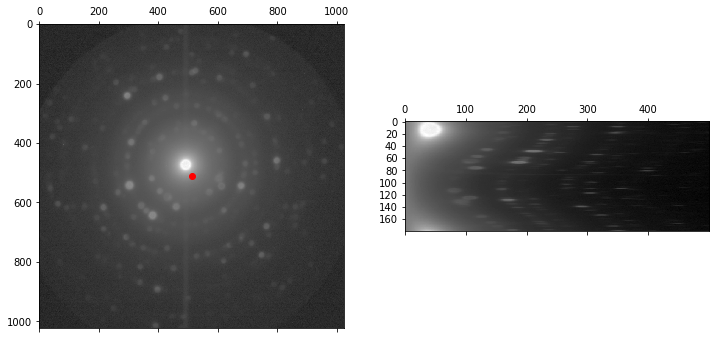

In [366]:
# Get initial polar transform

calibration_image = CBEDmean160
mask = mask160
# x0_init=430
# y0_init=500
x0_init=None
y0_init=None
dr=1             # in pixels
dtheta=2         # in degrees
r_range=500      # either [min,max] or just max --> [0,max]

pet = polar_elliptical_transform(calibration_image=calibration_image,
                                 mask=mask,
                                 x0_init=x0_init,
                                 y0_init=y0_init,
                                 dr=dr,
                                 dtheta=dtheta,
                                 r_range=r_range)
pet.get_polar_transform()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(pet.calibration_image**0.2)
ax1.scatter(pet.coeffs[1],pet.coeffs[0],color='r')
ax2.matshow(pet.polar_ar**0.2)
plt.show()

Analyzing: |**************************************************| 100.0% Complete


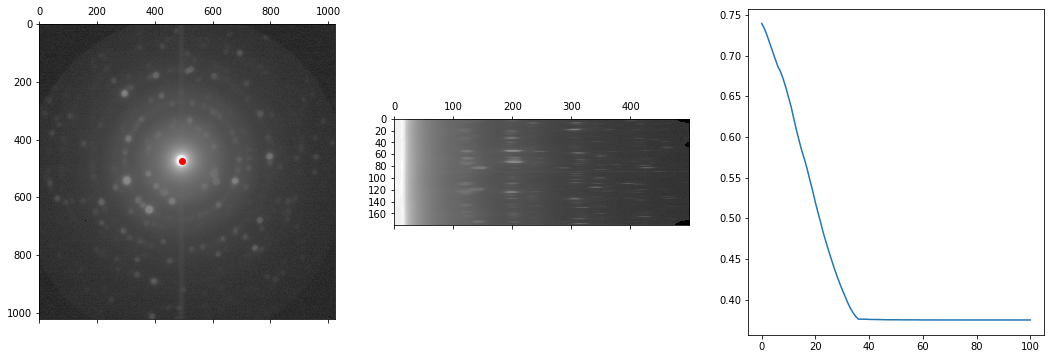

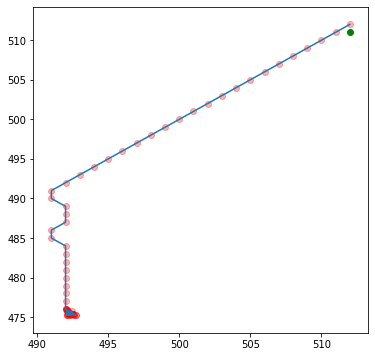

In [367]:
# Fit center

n_iter=100
step_size_x0_init=1
step_size_y0_init=1
step_scale=0.9

x0,y0,scores,xs,ys = pet.fit_origin(n_iter=n_iter,
                              step_size_x0_init=step_size_x0_init,
                              step_size_y0_init=step_size_y0_init,
                              step_scale=step_scale)

# Show
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.matshow(pet.calibration_image**0.2)
ax1.scatter(y0,x0,color='r')
ax2.matshow(pet.polar_ar**0.2)
ax3.plot(np.arange(len(scores)),scores)
plt.show()

fig,ax = plt.subplots(figsize=(6,6))
ax.plot(ys,xs)
ax.scatter(ys,xs,color='r',alpha=0.3)
ax.scatter(ys[0],xs[1],color='g')
plt.show()

In [315]:
pet.coeffs

array([430.43451107, 491.3330422 ,   1.        ,   1.        ,
         0.        ])

In [221]:
pet.coeffs

array([490.41694093, 480.69946779,   1.        ,   1.        ,
         0.        ])

In [39]:
np.sum(CBEDmean300[x_inds,y_inds]*weights,axis=1)

array([1328374.46002784, 1319710.12307677, 1341828.82272614,
       1334801.18351657])

In [32]:
CBEDmean300[x_inds,y_inds] * weights

array([[  1.05877392,   3.31872643,   5.57776166, ...,   2.43210113,
          2.68530069,   2.55058348],
       [  1.05036202,   3.17825713,   5.53795324, ...,   3.53513165,
          3.12023838,   3.43555839],
       [123.17278067, 120.37162516, 122.14922661, ...,   6.29540702,
          5.62948486,   6.6232906 ],
       [120.56200857, 121.07792505, 118.35847969, ...,   6.72448494,
          8.76504189,   7.83789778]])

In [22]:
np.ravel_multi_index((xF  ,yF  ),(Rx,Ry))

array([523775, 522751, 521727, ...,  14856,  13832,  12808])

In [26]:
rr.shape

(180, 500)

In [27]:
len(theta_bins)

180

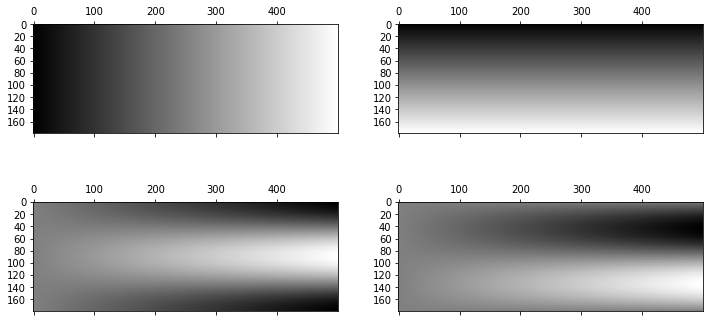

In [6]:
x0 = rr * np.cos(tt)
y0 = rr * np.sin(tt)

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,6))
ax11.matshow(rr)
ax12.matshow(tt)
ax21.matshow(x0)
ax22.matshow(y0)
plt.show()

#### 20190307 - no beam stop

In [370]:
fp160 = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_30x30_ss30nm_0p1s_spot8_alpha=0p48_bin2_cl-160mm_300kV.dm4"
fp300 = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_30x30_ss30nm_0p1s_spot8_alpha=0p48_bin2_cl-300mm_300kV.dm4"
fp600 = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_30x30_ss30nm_0p1s_spot8_alpha=0p48_bin2_cl-600mm_300kV.dm4"

In [371]:
dc160 = py4DSTEM.file.io.read(fp160)

/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_30x30_ss30nm_0p1s_spot8_alpha=0p48_bin2_cl-160mm_300kV.dm4 is not a py4DSTEM file.
Reading with hyperspy...


### Depr

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from matplotlib.patches import Circle, Ellipse

from py4DSTEM.file.io import read
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion

In [3]:
# Get data

fp_braggpeaks = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_Bragg_disks_shift_corrected.h5"
fp_braggvectormap = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_deconvolution.h5"

braggpeaks = read(fp_braggpeaks)
braggvectormap = read(fp_braggvectormap).data2D

R_Nx,R_Ny = braggpeaks.shape
Q_Nx,Q_Ny = 1024,1024

/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_Bragg_disks_shift_corrected.h5 is a py4DSTEM file, v0.2. Reading...
/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_deconvolution.h5 is a py4DSTEM file, v0.2. Reading...


### Measure elliptical distortion

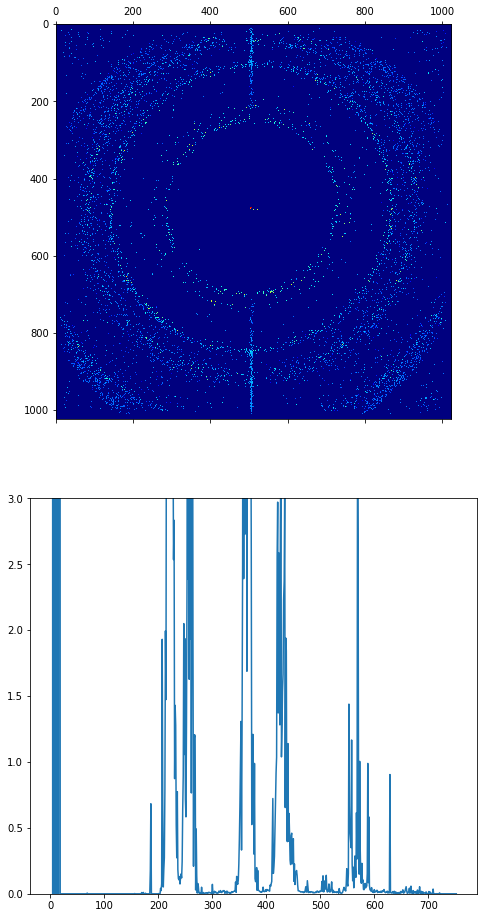

In [4]:
# Show braggvectormap, calculate radial integral

ymax=3
power=0.1

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

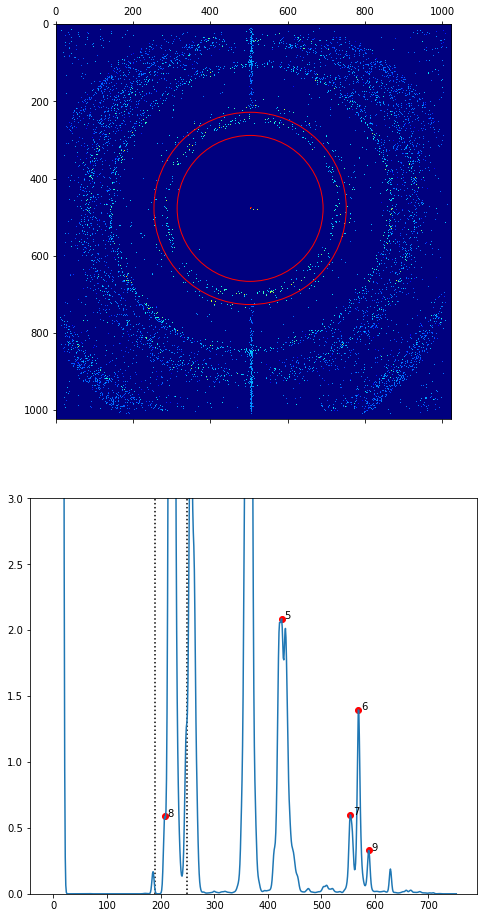

In [5]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 2
annulus_width = 60

# Display params
ymax=3
text_offset = 5
power = 0.1
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

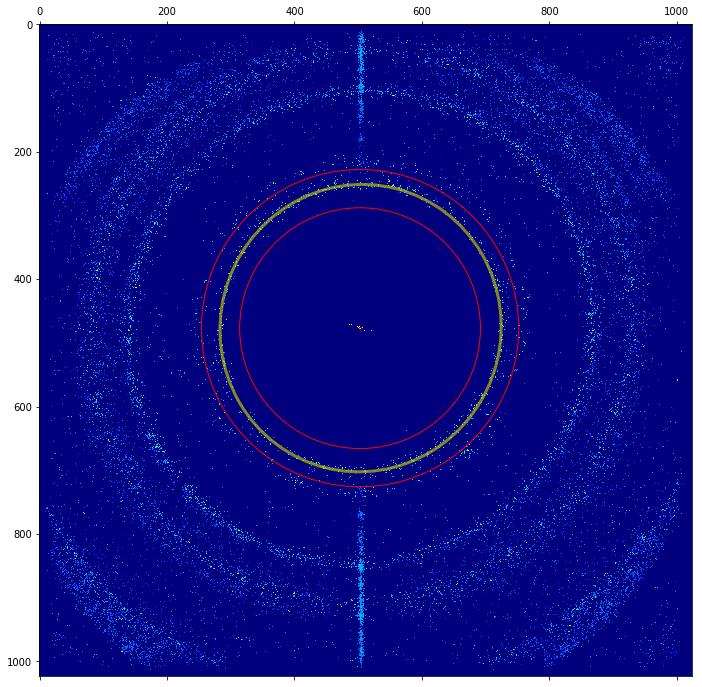

Measured elliptical distortion of 2.49%


In [6]:
# Measure elliptical distortion

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Measure with a mask
# mask = np.ones_like(braggvectormap,dtype=bool)
# mask[:,int(y0-10):int(y0+10)] = False
# ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer, mask)
# x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**0.1,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a,b)/min(a,b) - 1)))

### Correct distortions

In [7]:
braggpeaks_corrected = correct_elliptical_distortion(braggpeaks, ellipse_params)

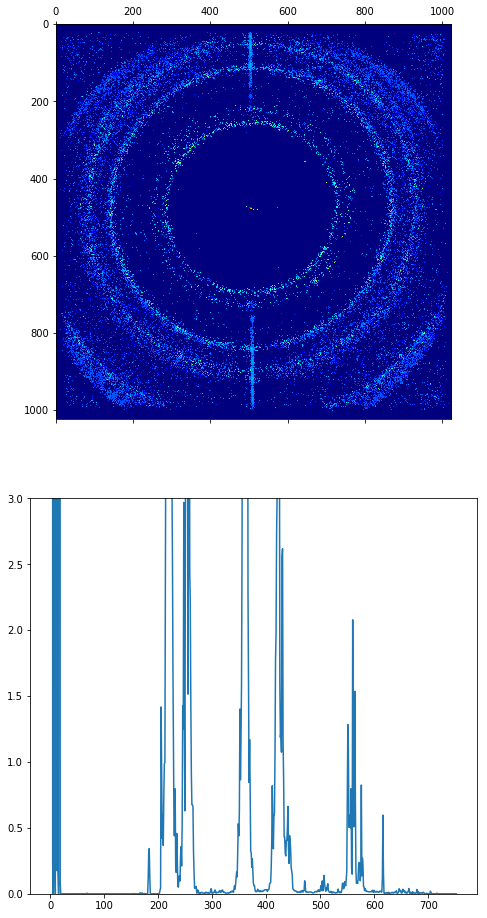

In [8]:
# Get new Bragg vector map and radial integral

ymax=3
power=0.1

braggvectormap_corrected = get_bragg_vector_map(braggpeaks_corrected,Q_Nx,Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_corrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_corrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_corrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

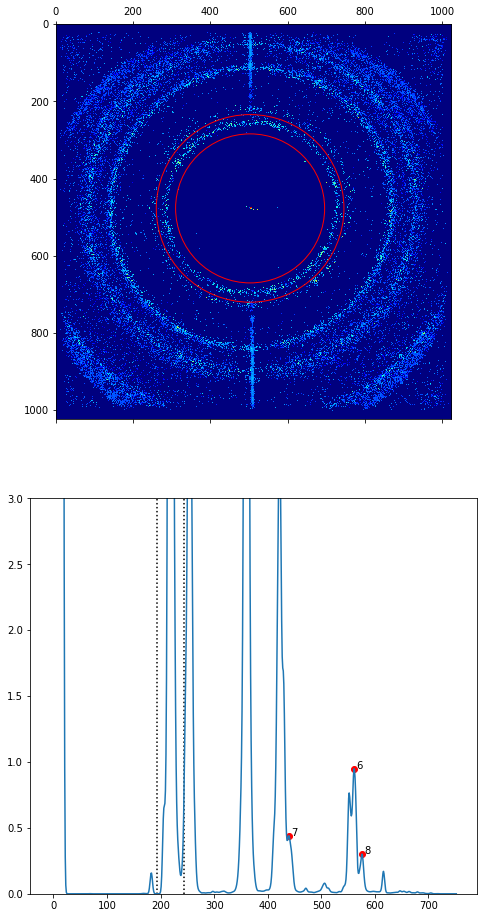

In [9]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 2
annulus_width = 50

# Display params
ymax=3
text_offset = 5
power = 0.1
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_corrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

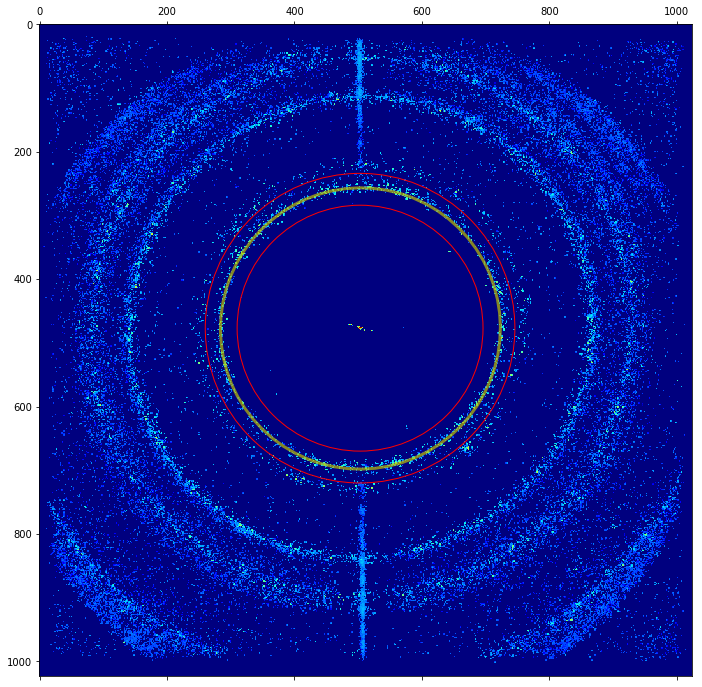

Measured elliptical distortion of 0.625%


In [10]:
# Measure elliptical distortion

ellipse_params_corrected,_ = measure_elliptical_distortion(braggvectormap_corrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params_corrected

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_corrected**0.1,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a,b)/min(a,b) - 1)))

### Relevant Mathematics

The discussion below includes the formalism for:

- the elliptical fitting routine
- conversion between the two representations of ellipses used here
- derivation of the transformation used to correct the measured elliptical distortions

#### Fitting ellipses

The representation of an ellipse we'll use for fitting purposes is

\begin{equation}
A(x-x_0)^2 + B(x-x_0)(y-y_0) + C(y-y0)^2 = 1
\end{equation}

The coordinates are $x$, $y$, and we will fit the five parameters $p = (x_0, y_0, A, B, C)$.  For some datapoint with intensity $I$ at $x_d$, $y_d$, we associate an error with respect to parameters $p$ given by $E(x_d,y_d,I; p) = I\cdot(A(x_d-x_0)^2 + B(x_d-x_0)(y_d-y_0) + C(y_d-y0)^2 - 1)$.  We find the best fit ellipse by finding

\begin{equation}
\underset{p}{\mathrm{argmin}} \sum_i E(x_i,y_i,I_i; p)^2
\end{equation}

where the sum runs over all datapoints $(x_i,y_i,I_i)$.

#### Converting representations

The parameters $x_0, y_0$ are the ellipse center; the parameters $A, B, C$ are related to the semiaxes and rotation.  Here, we briefly show that we can extract the semiaxes $a,b$ and rotation $\theta$ via:

\begin{equation}
\begin{matrix}
a^2    &=& \frac{2}{A+(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
b^2    &=& \frac{2}{A-(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
\theta &=& \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)
\end{matrix}
\end{equation}

To derive these conversions, we begin from the representation of an ellipse

\begin{equation}
\frac{x'^2}{a^2} + \frac{y'^2}{b^2} = 1
\end{equation}

where $a$ and $b$ are the semiaxes, oriented along the $x'$ and $y'$ axes, respectively.  Now let $(x',y')$ be rotated counterclockwise by $\theta$ with respect to a coordinate system $(x,y)$.  Then

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta   &  \sin\theta  \\
-\sin\theta  &  \cos\theta
\end{pmatrix}
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}

and the ellipse is

\begin{equation}
\frac{(x\cos\theta + y\sin\theta)^2}{a^2} + \frac{(-y\sin\theta + x\cos\theta)^2}{b^2} = 1
\end{equation}

which is equivalent to the ellipse from the prior section, where

\begin{equation}
\begin{matrix}
A &=& \frac{\cos^2\theta}{a^2} + \frac{\sin^2\theta}{b^2}        \\
B &=& 2\sin\theta\cos\theta\left(\frac{-a^2+b^2}{a^2b^2}\right)  \\
C &=& \frac{\sin^2\theta}{a^2} + \frac{\cos^2\theta}{b^2}
\end{matrix}
\end{equation}

The task at hand is to solve these three equations for $a, b, \theta$.

From the second equation, using $2\sin\theta\cos\theta = \sin2\theta$ we find $\frac{B}{\sin2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Subtracting the first and third equations and using $\cos^2\theta - \sin^2\theta = \cos2\theta$, we find $\frac{A-C}{\cos2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Setting these two results equal to one another, we find $\theta = \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)$.

Adding the first and third equations gives $A+C=\frac{1}{a^2}+\frac{1}{b^2}$, and combining this with $\frac{B}{\sin2\theta}  =\frac{1}{a^2} - \frac{1}{b^2}$ by adding and subtracting gives, respectively:

\begin{equation}
a^2 = \frac{2}{A+\frac{B}{\sin2\theta}+C}        \\
b^2 = \frac{2}{A-\frac{B}{\sin2\theta}+C} 
\end{equation}

Recalling that $\sin(\tan^{-1}(\alpha)) = \frac{\alpha}{\sqrt{1+\alpha^2}}$, we substitute our expression for $\theta$ into $\sin2\theta$ and find $\frac{B}{\sin2\theta} = (A-C)\left(1+(\frac{B}{A-C})^2\right)^\frac{1}{2}$.  Substituting into the expressions above for $a^2$ and $b^2$ completes the derivation.

#### Transforming ellipses to circles

To correct any measured elliptical distortion, we apply an affine linear transformation of the form

\begin{equation}
T = 
\begin{pmatrix}
T_{11}   &   T_{12}   \\
T_{21}   &   T_{22}
\end{pmatrix}
\end{equation}

Geometrically, if we think of the ellipse as the conic section resulting from a plane intersecting a cone, we want a transformation which tilts the plane until it is perpendicular with the cone's axis.  Here, we use the transformation which compresses the ellipse the major axis until it is the same size as the minor axis.

For ellipse parameters $a$, $b$, $\theta$, assume without loss of generality that $a>b$.  We want a transformation which compresses by a factor of $s = \frac{b}{a}$.  If $\theta = 0$, then

\begin{equation}
T_0 = 
\begin{pmatrix}
s   &   0   \\
0   &   1
\end{pmatrix}
\end{equation}

For finite $\theta$, we simply rotate this transformation matrix, using the usual rotation matrix $R$:

\begin{align}
T &= R^{-1}T_0R \\
  &=
\begin{pmatrix}
    \cos\theta   &   -\sin\theta   \\
    \sin\theta   &   \cos\theta
\end{pmatrix}
\begin{pmatrix}
    s   &   0   \\
    0   &   1
\end{pmatrix}
\begin{pmatrix}
     \cos\theta   &   \sin\theta   \\
    -\sin\theta   &   \cos\theta
\end{pmatrix}  \\
 &=
\begin{pmatrix}
    \sin^2\theta + s\cdot\cos^2\theta     &    \sin\theta\cos\theta(s-1)          \\
    \sin\theta\cos\theta(s-1)             &    s\cdot\sin^2\theta + \cos^2\theta
\end{pmatrix}
\end{align}

For an original datapoint $(x,y)$, if we neglect translation of the center of coordinates here for simplicity, the  corresponding elliptical distortion corrected datapoint $(x',y')$ will be

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
T
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}